# importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import nltk
from wordcloud import WordCloud

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.classify.scikitlearn import SklearnClassifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('train.csv').rename(columns={'sms':'text'})
df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [ ]:
red_palette = sns.color_palette("Blues_r", 2)
red_palette_c = sns.color_palette("Blues_r", as_cmap=True)

# text length and label distrubution

Text(0, 0.5, 'Count')

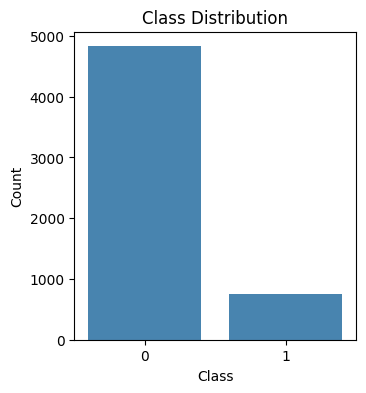

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

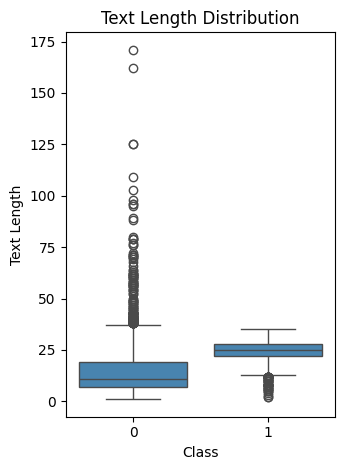

In [ ]:
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
sns.boxplot(x='label', y='text_length', data=df)
plt.title('Text Length Distribution')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.tight_layout()
plt.show()

# text length distribution with KDE


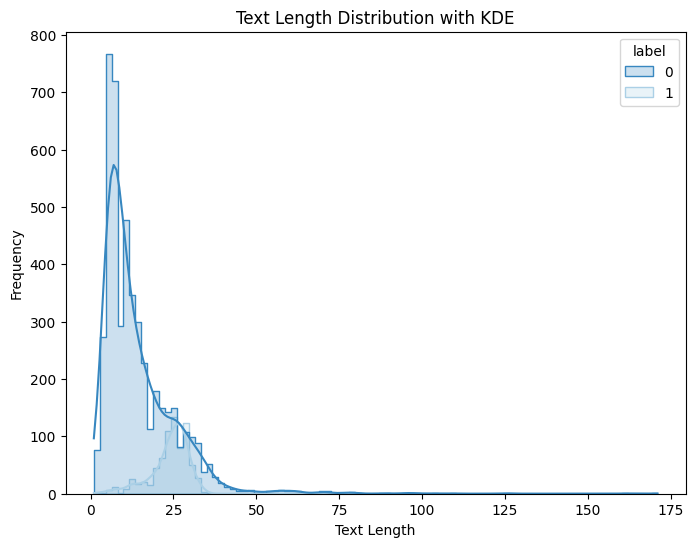

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
sns.set_palette(red_palette)
sns.histplot(data=df, x='text_length', hue='label', kde=True, element='step')
plt.title('Text Length Distribution with KDE')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# word cloud for 2 label

In [ ]:
ham_text = " ".join(df[df['label'] == 0]['text'])
spam_text = " ".join(df[df['label'] == 1]['text'])
ham_wordcloud = WordCloud(width=600, height=600, background_color='black', colormap=red_palette_c).generate(ham_text)
spam_wordcloud = WordCloud(width=600, height=600, background_color='white', colormap=red_palette_c).generate(spam_text)
ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

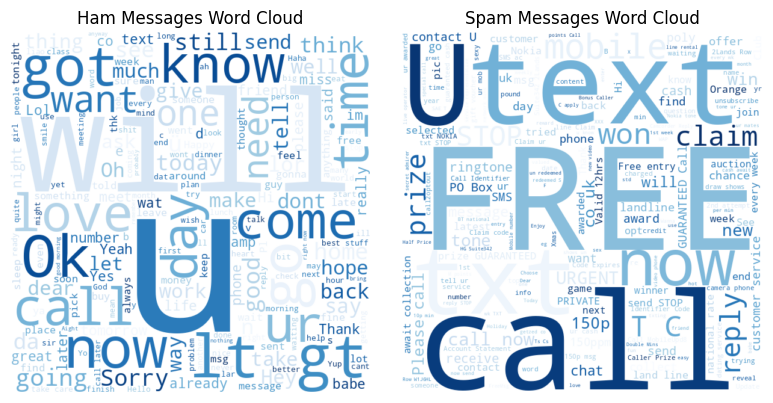

In [ ]:
plt.figure(figsize=(8, 4), dpi=100)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()


# text modeling and preprocessing

In [ ]:
def preprocess_text(text):
#tokenization
    words = word_tokenize(text)
#to lowecase
    words = [word.lower() for word in words if word.isalnum()]
#remove stopwords
    words = [word for word in words if word not in stopwords.words("english")]
#concate tokens
    return " ".join(words)

In [ ]:
df['text'] = df['text'].apply(preprocess_text)

# TF-IDF Vectorization and Multinomial Naive Bayes Classification

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['text']).toarray()
y = df['label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#alpha=0.1 is more accurate
sklearn_classifier = MultinomialNB(alpha=.1)
sklearn_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

# NLTK Classifier Wrapper

In [ ]:
#Constructor
class SklearnNLTKClassifier(nltk.classify.ClassifierI):
    def __init__(self, classifier):
        self._classifier = classifier
#Predict for one feature
    def classify(self, features):
        return self._classifier.predict([features])[0]
#Predict for multiple features
    def classify_many(self, featuresets):
        return self._classifier.predict(featuresets)
#Shows error for not implementating
    def prob_classify(self, features):
        raise NotImplementedError("Probability estimation not available.")
 #return
    def labels(self):
        return self._classifier.classes_

In [ ]:
nltk_classifier = SklearnNLTKClassifier(sklearn_classifier)

# prediction of data

In [ ]:
y_pred = nltk_classifier.classify_many(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
acc = f"Accuracy is : {accuracy:.2f}"

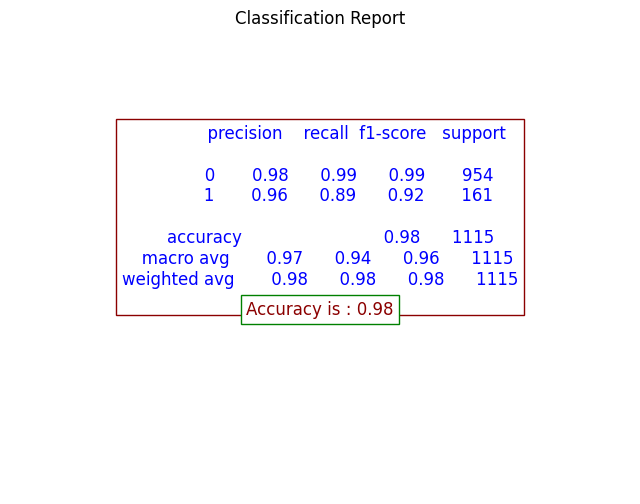

In [ ]:
plt.figure(figsize=(8, 6), dpi=100)
plt.text(0.5, 0.6, report, fontsize=12, color='blue', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='darkred'))
plt.text(0.5, 0.4, acc, fontsize=12, color='darkred', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='green'))
plt.title('Classification Report')
plt.axis('off')
plt.show()

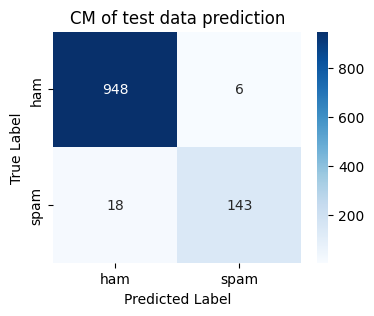

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3), dpi=100)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('CM of test data prediction')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()